# Visualization of CAR map
Results calculated in R
Visualizing in Python
## Model 2

In [1]:
%matplotlib inline
import sys
sys.path.append('/apps')
import django
django.setup()
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
## Use the ggplot style
plt.style.use('ggplot')

In [2]:
#file = '/outputs/presence_only_models/predictors/dataset100x100-puebla-p9/0-pred.csv'
#PDF = read.csv(file)
## REad adjancency matrix
mat_filename = "/outputs/training_data_sample_puebla_p9_abies_pinophyta_adjmat.npy"


TDF = pd.read_csv("/outputs/training_data_sample_puebla_p9_abies_pinophyta.csv")
## Order it according to the id of the cell
## This is important because the adjancy matrix rows need to be the same

TDF.sort_values(by='cell_ids',inplace=True)

    

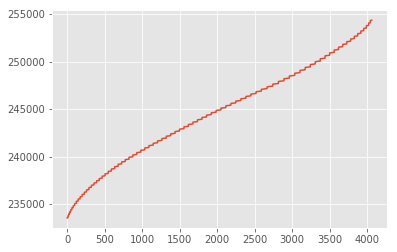

In [3]:
plt.plot(TDF.cell_ids.values)

In [4]:
import utilities.data_extraction as de
nTDF = de.toGeoDataFrame(TDF,xcoord_name='Longitude',ycoord_name='Latitude')

## Extract the polygons from cells


In [5]:
from mesh.models import initMesh
from django.contrib.gis.geos import Point, Polygon
#coord = -99.76
#coord = 17.55
#xcoord = -98.219
#ycoord = 19.05
xcoord = -97.237
ycoord = 19.482
p = Point(xcoord,ycoord,srid=4326)
radii = np.linspace(0.08,2,10)
polys = map(lambda r : p.buffer(r),radii)
mexmesh = initMesh(11)
## restrict the polygons to the polygon n 3
polys = [polys[9]]
intersected_cells = map(lambda poly : mexmesh.objects.filter(cell__intersects=poly),polys)
# Number of selected cells in each buffer
values = map(lambda l : list(l.values_list('id',flat=True)),intersected_cells)
## Change to network database
from traversals.strategies import idsToCells
cells = map(lambda level : list(idsToCells(level)),values)


import shapely.wkt as wkt



DEBUG Changed MESH TABLE SPACE
INFO Compiling Query and asking the Graph Database


In [6]:
ids_poly = map(lambda c : (c.id,wkt.loads(c.polygon.wkt)),cells[0])

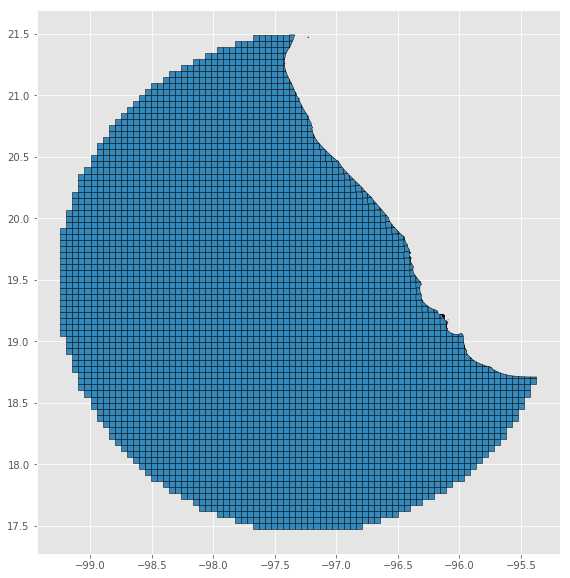

In [7]:
import geopandas as gpd
gg = gpd.GeoDataFrame(ids_poly,columns=['id','geom'])
gg.set_geometry('geom',inplace=True)
gg.set_index('id',inplace=True)
plt.rcParams['figure.figsize'] = [10, 10]
gg.plot(edgecolor='black')

In [8]:
TDF.columns

Index([u'Unnamed: 0', u'LUCA', u'Plantae', u'Pinophyta', u'Abies', u'cell_ids',
       u'Dist.to.road_m', u'Elevation_m', u'MaxTemp_m', u'MeanTemp_m',
       u'MinTemp_m', u'Population_m', u'Precipitation_m', u'SolarRadiation_m',
       u'VaporPres_m', u'WindSp_m', u'Longitude', u'Latitude', u'wwf_mhtnum',
       u'wwf_mhtnam', u'covid', u'name', u'cov_id', u'tipos', u'geometry'],
      dtype='object')

### Develop here new pseudo-absences strategies designs
This has been done in R. 
Let's see how we can use it from here

> IMPOSIBLE TO INSTALL new version of Rpy2 due to stupid python 2/7
Continue evading the problem, as the water....

In [90]:
# Read from csv

file_ = '/outputs/presence_only_models/modelCAR_model2_fitted.csv'
fitted_sample = pd.read_csv(file_)
fitted_sample = fitted_sample.drop(fitted_sample.columns[0],axis=1)
fitted_sample.set_index(fitted_sample.columns[0],inplace=True)
fitted_sample.set_index(fitted_sample.index.astype('int'),inplace=True)
#fitted_sample = fitted_sample.transpose()

In [30]:
## Sample from the posterior
from scipy.stats import bernoulli
y_ = lambda p : bernoulli.rvs(p=p,size=1)
Y = fitted_sample.applymap(y_)

In [31]:
# Reduce function
def getProb(X,p=0.0,n_sample=100):
    # there is a sample here
    #X = X.sample(n=n_sample,axis=0)
    return(sum(X[X > p]) / sum(X))
    

In [ ]:
SY = Y.sum(axis=1) / Y.shape[1]

In [103]:
## Calculate prob.
SY = Y.sum(axis=1) / Y.shape[1]
DFSY = pd.DataFrame([fitted_sample.index,SY]).transpose()
DFSY.columns = ['idx','PY']
DFSY.set_index(fitted_sample.index.astype('int'),inplace=True)

In [104]:
DFSY.shape

(4061, 2)

In [47]:
fitted_sample.index

Int64Index([233546, 233547, 233548, 233549, 233550, 233551, 233552, 233553,
            233747, 233748,
            ...
            244369, 244370, 244371, 244372, 244373, 244374, 244375, 244376,
            244377, 244378],
           dtype='int64', name=u'V1', length=10000)

In [105]:
## Join it with geodataframe
gdf = gg.join(DFSY,how='inner')

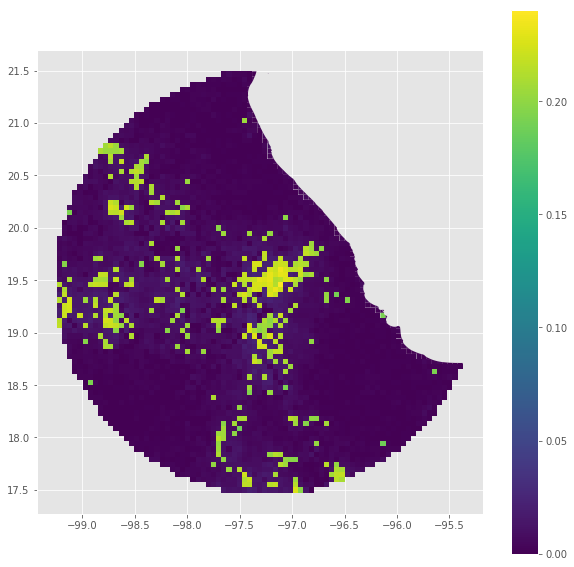

In [108]:
gdf.plot(column='PY',legend=True)

In [11]:
# Reduce function
def mean(X,p=0.0,n_sample=100):
    # there is a sample here
    X = X.mean()
    return(X)


In [12]:
## Calculate probs on the fly
import functools as ft


def fullProbFromDF(DF, p=0.0,n_sample=500,showPlot=True):
    f = ft.partial(getProb,p=p,n_sample=n_sample)
    fp = DF.apply(f,axis=1)
    fp = pd.DataFrame(fp,columns=['p'] )
    return(fp)

In [13]:
#new = gg.join(fp,how='inner')
xx = np.linspace(0,1,100)
things = map(lambda p : fullProbFromDF(fitted_sample,p=p),xx)


In [14]:
new = pd.concat(things,axis=1)
new.columns = xx
new.set_index(new.columns[0])
##
gdf = gg.join(new,how='inner')


In [15]:

def plot(df, p):
    # df needs to be a geopandas object
    #fp = pd.concat([ geoDataframe,fp],axis=0 )
    fig, ax = plt.subplots(1, figsize=(12, 12))
    name = df.columns[p]
    ac = df.plot(column=name,cmap=plt.cm.viridis,vmin=0.0,vmax=1.0,legend=True,ax=ax,edgecolor='black')
    fig.suptitle('Joint. Probability of presence more than %s'%name)
    plt.show()
    return(None)

,geom,0.0,0.010101010101,0.020202020202,0.030303030303,0.040404040404,0.0505050505051,0.0606060606061,0.0707070707071,0.0808080808081,...,0.909090909091,0.919191919192,0.929292929293,0.939393939394,0.949494949495,0.959595959596,0.969696969697,0.979797979798,0.989898989899,1.0


In [16]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual,FloatSlider,IntSlider
import ipywidgets as widgets

aW50ZXJhY3RpdmUoY2hpbGRyZW49KEludFNsaWRlcih2YWx1ZT0zNywgZGVzY3JpcHRpb249dSdwJywgbWluPTEpLCBCdXR0b24oZGVzY3JpcHRpb249dSdSdW4gSW50ZXJhY3QnLCBzdHlsZT3igKY=


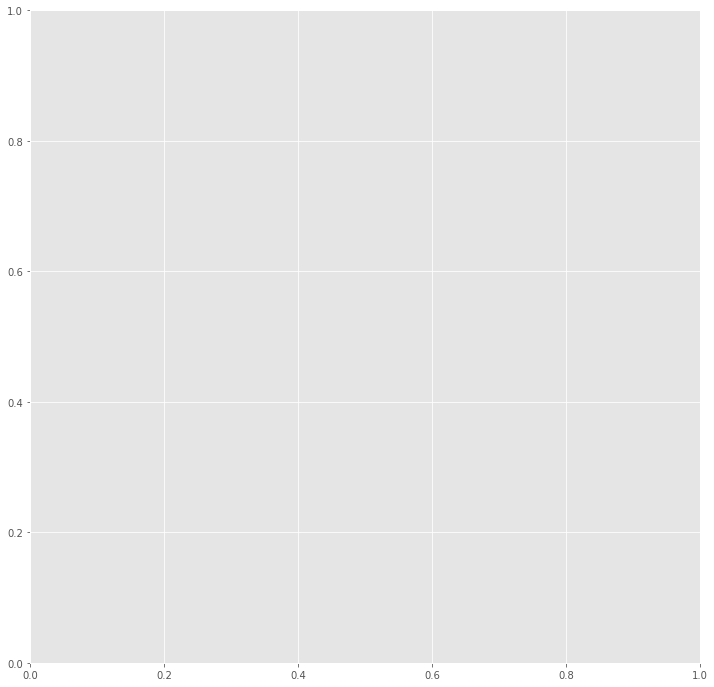

In [17]:
f = ft.partial(plot,gdf)
interact_manual(f, p=IntSlider(min=1,max=100,value=37),continuous_update=False);

# Looking for the phase transition region

In [28]:
from scipy.stats import entropy as f_entropy
data = gdf.iloc[:,1:]
means = data.apply(mean)
entropy = data.apply(f_entropy)

In [23]:
from bokeh.io import output_notebook, output_file
from bokeh.plotting import figure, show
from bokeh.models import HoverTool,Range1d,LinearAxis
output_notebook()

Loading BokehJS ...

In [24]:
_tools_to_show = 'box_zoom,pan,save,hover,reset,tap,wheel_zoom' 
fig = figure(title='Phase transition in GMRF',tools=_tools_to_show)
fig.xaxis.axis_label = 'Probability of presence (p)'
fig.yaxis.axis_label_text_color = 'blue'
fig.yaxis.axis_label = 'Probability of exceeding p'
hover = fig.select(dict(type=HoverTool))
hover.mode = 'vline'
hover.tooltips = [("P","@x"),("Ex/entr","@y")]
fig.line(x=data.columns,y=means,line_width=4,color='blue')
fig.y_range = Range1d(0,1)
fig.extra_y_ranges = {"entropy":Range1d(start=0,end=9)}
fig.add_layout(LinearAxis(y_range_name="entropy",axis_label='Entropy',axis_label_text_color='orange'),'right')

fig.line(x=data.columns,y=entropy,line_width=4,color='orange',y_range_name="entropy")

GlyphRenderer(id='1202', ...)

In [25]:

show(fig)

In [29]:
_tools_to_show = 'box_zoom,pan,save,hover,reset,tap,wheel_zoom'

fig = figure(title='Phase transition in Gradient ',tools=_tools_to_show)
fig.xaxis.axis_label = 'Probability of presence (p)'
fig.yaxis.axis_label_text_color = 'blue'
fig.yaxis.axis_label = 'Probability of exceeding p'
hover = fig.select(dict(type=HoverTool))
hover.mode = 'vline'
hover.tooltips = [("P","@x"),("Ex/entr","@y")]
fig.line(x=data.columns,y=np.gradient(means),line_width=4,color='blue')
#fig.y_range = Range1d(0,1)
#fig.extra_y_ranges = {"entropy":Range1d(start=0,end=9)}
#fig.add_layout(LinearAxis(y_range_name="entropy",axis_label='Entropy',axis_label_text_color='orange'),'right')

fig.line(x=data.columns,y=np.gradient(entropy),line_width=4,color='orange')#,y_range_name="entropy")

GlyphRenderer(id='1197', ...)

In [32]:

show(fig)